# Import Libraries

In [ ]:
import pandas as pd 
import numpy as np
import re
import collections
import matplotlib.pyplot as plt
# Packages for data preparation
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
# Packages for modeling
from keras import models
from keras import layers
from keras import regularizers
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Load Dataset 
Link - https://www.kaggle.com/crowdflower/twitter-airline-sentiment

In [ ]:
df = pd.read_csv('/content/Tweets.csv')
df=df.drop(df[df['airline_sentiment_confidence']<0.5].index,axis=0)
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)
5,570300767074181121,negative,1.0000,Can't Tell,0.6842,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica seriously would pay $30 a fligh...,NaN,2015-02-24 11:14:33 -0800,NaN,Pacific Time (US & Canada)


# Data Analysis

In [ ]:
df['airline_sentiment'].value_counts()

negative    9115
neutral     2997
positive    2292
Name: airline_sentiment, dtype: int64

Total number of tweets for each airline 
  airline
United            3760
US Airways        2876
American          2733
Southwest         2372
Delta             2169
Virgin America     494
Name: airline_sentiment, dtype: int64


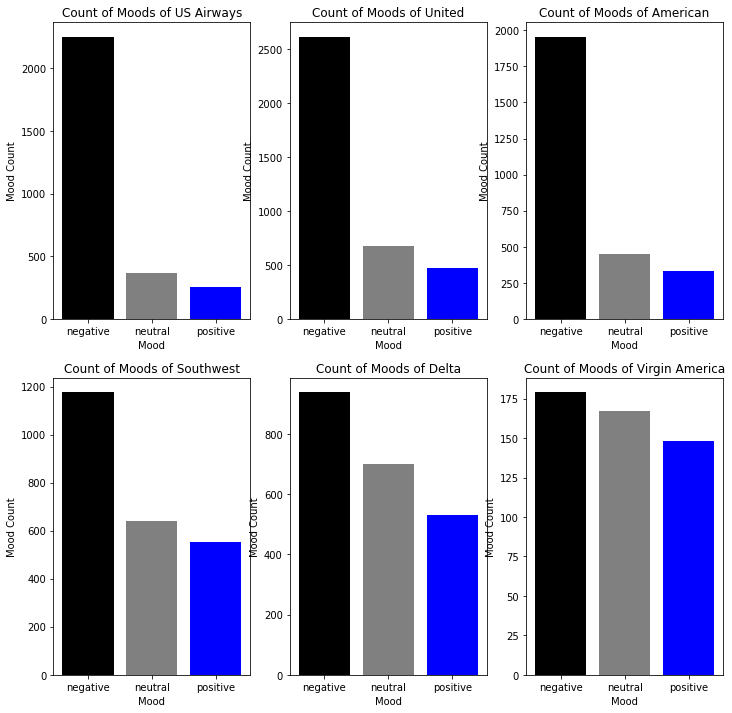

In [ ]:
print("Total number of tweets for each airline \n ",df.groupby('airline')['airline_sentiment'].count().sort_values(ascending=False))
airlines= ['US Airways','United','American','Southwest','Delta','Virgin America']
plt.figure(1,figsize=(12, 12))
for i in airlines:
    indices= airlines.index(i)
    plt.subplot(2,3,indices+1)
    new_df=df[df['airline']==i]
    count=new_df['airline_sentiment'].value_counts()
    Index = [1,2,3]
    plt.bar(Index,count, color=['black', 'grey', 'blue'])
    plt.xticks(Index,['negative','neutral','positive'])
    plt.ylabel('Mood Count')
    plt.xlabel('Mood')
    plt.title('Count of Moods of '+i)

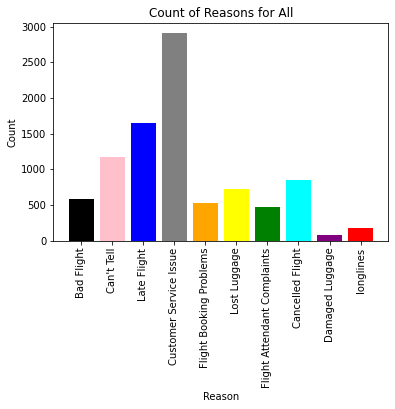

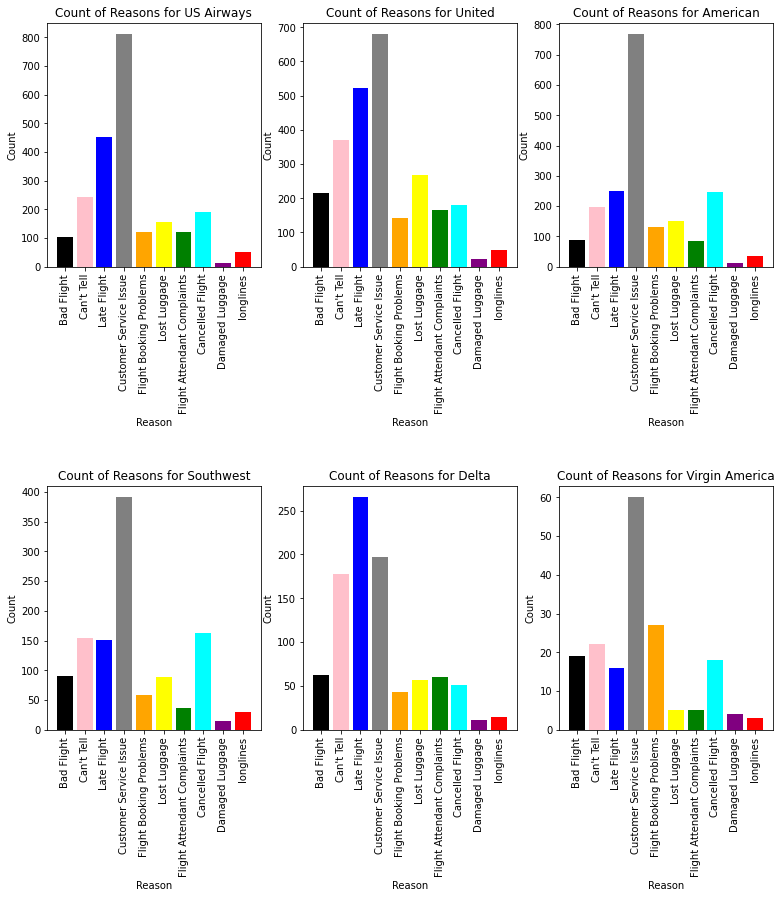

In [ ]:
#get the number of negative reasons
df['negativereason'].nunique()

NR_Count=dict(df['negativereason'].value_counts(sort=False))
def NR_Count(Airline):
    if Airline=='All':
        a=df
    else:
        a=df[df['airline']==Airline]
    count=dict(a['negativereason'].value_counts())
    Unique_reason=list(df['negativereason'].unique())
    Unique_reason=[x for x in Unique_reason if str(x) != 'nan']
    Reason_frame=pd.DataFrame({'Reasons':Unique_reason})
    Reason_frame['count']=Reason_frame['Reasons'].apply(lambda x: count[x])
    return Reason_frame
def plot_reason(Airline):
    
    a=NR_Count(Airline)
    count=a['count']
    Index = range(1,(len(a)+1))
    plt.bar(Index,count, color=['black','pink','blue','grey','orange','yellow','green','cyan','purple','red'])
    plt.xticks(Index,a['Reasons'],rotation=90)
    plt.ylabel('Count')
    plt.xlabel('Reason')
    plt.title('Count of Reasons for '+Airline)
    
plot_reason('All')
plt.figure(2,figsize=(13, 13))
for i in airlines:
    indices= airlines.index(i)
    plt.subplot(2,3,indices+1)
    plt.subplots_adjust(hspace=0.9)
    plot_reason(i)

# Approach 1 - Machine Learning 



In [ ]:
df = df[['text', 'airline_sentiment']]
df.head()

## Clean Dataset

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
corpus = []
for i in range(0, 14640):
  review = re.sub('[^a-zA-Z]', ' ', df['text'][i])           #remove special charaters
  review = review.lower()                                    #convert into lower case
  review = review.split()                                    #split sentences
  ps = PorterStemmer()                                       #trying without stemmer
  all_stopwords = stopwords.words('english')                 #remove stopwords
  all_stopwords.remove('not')                                #remove not
  #review = [ps.stem(word) for word in review if not word in set(all_stopwords)]
  review = [word for word in review if not word in set(all_stopwords)]      #apply to all dataset
  review = ' '.join(review)
  corpus.append(review)                                     #append into corpus variable
corpus.head()

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features = 10000,stop_words=['virginamerica','unit'])         #set vectorization
X = cv.fit_transform(corpus).toarray()                                                 #apply into data
y = df['airline_sentiment']
sentiment_ordering = ['negative', 'neutral', 'positive']
y = y.apply(lambda x: sentiment_ordering.index(x))                                     #do one hot encoding

## Training Model

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
model=MultinomialNB()

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)                     #apply train test split
model.fit(X_train,y_train)                                                            #train model

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

## Results

In [ ]:
y_pred=model.predict(X_test)
from sklearn.metrics import classification_report
cf=classification_report(y_test,y_pred)
print(cf)

              precision    recall  f1-score   support

           0       0.82      0.89      0.85      2771
           1       0.61      0.45      0.52       944
           2       0.68      0.67      0.68       677

    accuracy                           0.76      4392
   macro avg       0.70      0.67      0.68      4392
weighted avg       0.75      0.76      0.75      4392



# Approach 2 - Deep Learning

In [ ]:
df = df[['text', 'airline_sentiment']]
df.head()

## Predefining Variables

In [ ]:
NB_WORDS = 10000  # Parameter indicating the number of words we'll put in the dictionary
VAL_SIZE = 1000  # Size of the validation set
NB_START_EPOCHS = 20  # Number of epochs we usually start to train with
BATCH_SIZE = 64  # Size of the batches used in the mini-batch gradient descent

## Data Cleaning

In [ ]:
def remove_stopwords(input_text):
    stopwords_list = stopwords.words('english')
    # Some words which might indicate a certain sentiment are kept via a whitelist
    whitelist = ["n't", "not", "no"]
    words = input_text.split() 
    clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
    return " ".join(clean_words) 
    
def remove_mentions(input_text):
    return re.sub(r'@\w+', '', input_text)

In [ ]:
df.text = df.text.apply(remove_stopwords).apply(remove_mentions)
df.head(10)

,text,airline_sentiment
0,What said.,neutral
1,plus added commercials experience... tacky.,positive
2,today... Must mean need take another trip!,neutral
3,"really aggressive blast obnoxious ""entertainme...",negative
4,really big bad thing,negative
5,seriously would pay $30 flight seats playing. ...,negative
6,"yes, nearly every time fly VX “ear worm” won’t...",positive
7,Really missed prime opportunity Men Without Ha...,neutral
8,"Well, didn't…but NOW DO! :-D",positive
9,"amazing, arrived hour early. You're good me.",positive


## Spliting Data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.text, df.airline_sentiment, test_size=0.1, random_state=37)
print('# Train data samples:', X_train.shape[0])
print('# Test data samples:', X_test.shape[0])
assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]

# Train data samples: 13176
# Test data samples: 1464


## Tokenization

In [ ]:
tk = Tokenizer(num_words=NB_WORDS,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
               lower=True,
               split=" ")
tk.fit_on_texts(X_train)

print('Fitted tokenizer on {} documents'.format(tk.document_count))
print('{} words in dictionary'.format(tk.num_words))
print('Top 5 most common words are:', collections.Counter(tk.word_counts).most_common(5))

X_train_seq = tk.texts_to_sequences(X_train)
X_test_seq = tk.texts_to_sequences(X_test)
print('"{}" is converted into {}'.format(X_train[0], X_train_seq[0]))

Fitted tokenizer on 13176 documents
10000 words in dictionary
Top 5 most common words are: [('flight', 3540), ('not', 1420), ('no', 1354), ('get', 1220), ('t', 1123)]
"What said." is converted into [720, 1025, 56, 213, 321, 1920, 1205, 2892]


## One Hot Encoding and selecting number of **features**

In [ ]:
def one_hot_seq(seqs, nb_features = NB_WORDS):
    ohs = np.zeros((len(seqs), nb_features))
    for i, s in enumerate(seqs):
        ohs[i, s] = 1.
    return ohs

X_train_oh = one_hot_seq(X_train_seq)
X_test_oh = one_hot_seq(X_test_seq)

le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)
y_train_oh = to_categorical(y_train_le)
y_test_oh = to_categorical(y_test_le)

print('"{}" is converted into {}'.format(y_train[0], y_train_le[0]))
print('"{}" is converted into {}'.format(y_train_le[0], y_train_oh[0]))

"neutral" is converted into 0
"0" is converted into [1. 0. 0.]


## Spliting into Validation Data

In [ ]:
X_train_rest, X_valid, y_train_rest, y_valid = train_test_split(X_train_oh, y_train_oh, test_size=0.1, random_state=37)

assert X_valid.shape[0] == y_valid.shape[0]
assert X_train_rest.shape[0] == y_train_rest.shape[0]

print('Shape of validation set:',X_valid.shape)

Shape of validation set: (1318, 10000)


## Define Baseline Deep Learning Model & Training

In [ ]:
base_model = models.Sequential()
base_model.add(layers.Dense(64, activation='relu', input_shape=(NB_WORDS,)))
base_model.add(layers.Dropout(0.5))
base_model.add(layers.Dense(64, activation='relu'))
base_model.add(layers.Dropout(0.5))
base_model.add(layers.Dense(3, activation='softmax'))
print(base_model.summary())

base_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

history = base_model.fit(X_train_rest, y_train_rest, epochs=NB_START_EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_valid, y_valid), verbose=2)


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 64)                640064    
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 3)                 195       
Total params: 644,419
Trainable params: 644,419
Non-trainable params: 0
_________________________________________________________________
None


## Evaluation of Model

In [ ]:
def eval_metric(history, metric_name):
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]


    e = range(1, NB_START_EPOCHS + 1)


    plt.plot(e, metric, 'bo', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
    plt.legend()
    plt.show()

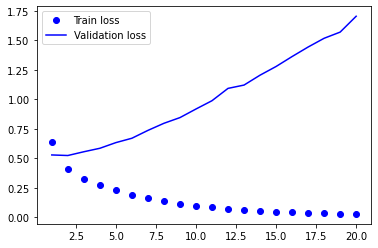

In [ ]:
eval_metric(base_history, 'loss')

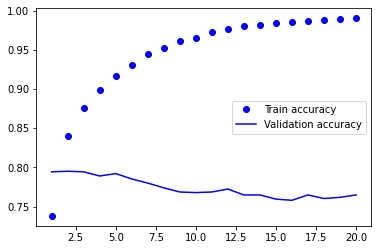

In [ ]:
eval_metric(base_history, 'accuracy')

## Testing on Test Data

In [ ]:
results = base_model.evaluate(X_test_oh, y_test_oh)

46/46 [==============================] - 0s 3ms/step - loss: 0.8306 - accuracy: 0.7883
